# AdaBoost

In [1]:
# importing relevant packages and functions
%run /Users/thomasadler/Desktop/futuristic-platipus/notebooks/ta_00_packages_functions.py

/Users/thomasadler/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Preparing data

In [2]:
#clean dataset
modelling_df=pd.read_csv(data_filepath + 'master_modelling_df.csv', index_col=0)

#check
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107184 entries, 0 to 108905
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   lat_deg                   107184 non-null  float64
 1   lon_deg                   107184 non-null  float64
 2   is_functioning            107184 non-null  int64  
 3   distance_to_primary       107184 non-null  float64
 4   distance_to_secondary     107184 non-null  float64
 5   distance_to_tertiary      107184 non-null  float64
 6   distance_to_city          107184 non-null  float64
 7   distance_to_town          107184 non-null  float64
 8   usage_cap                 107184 non-null  float64
 9   is_complex_tech           107184 non-null  int64  
 10  is_installed_after_2006   107184 non-null  int64  
 11  is_public_management      107184 non-null  int64  
 12  crucialness               107184 non-null  float64
 13  perc_hh_head_male         107184 non-null  f

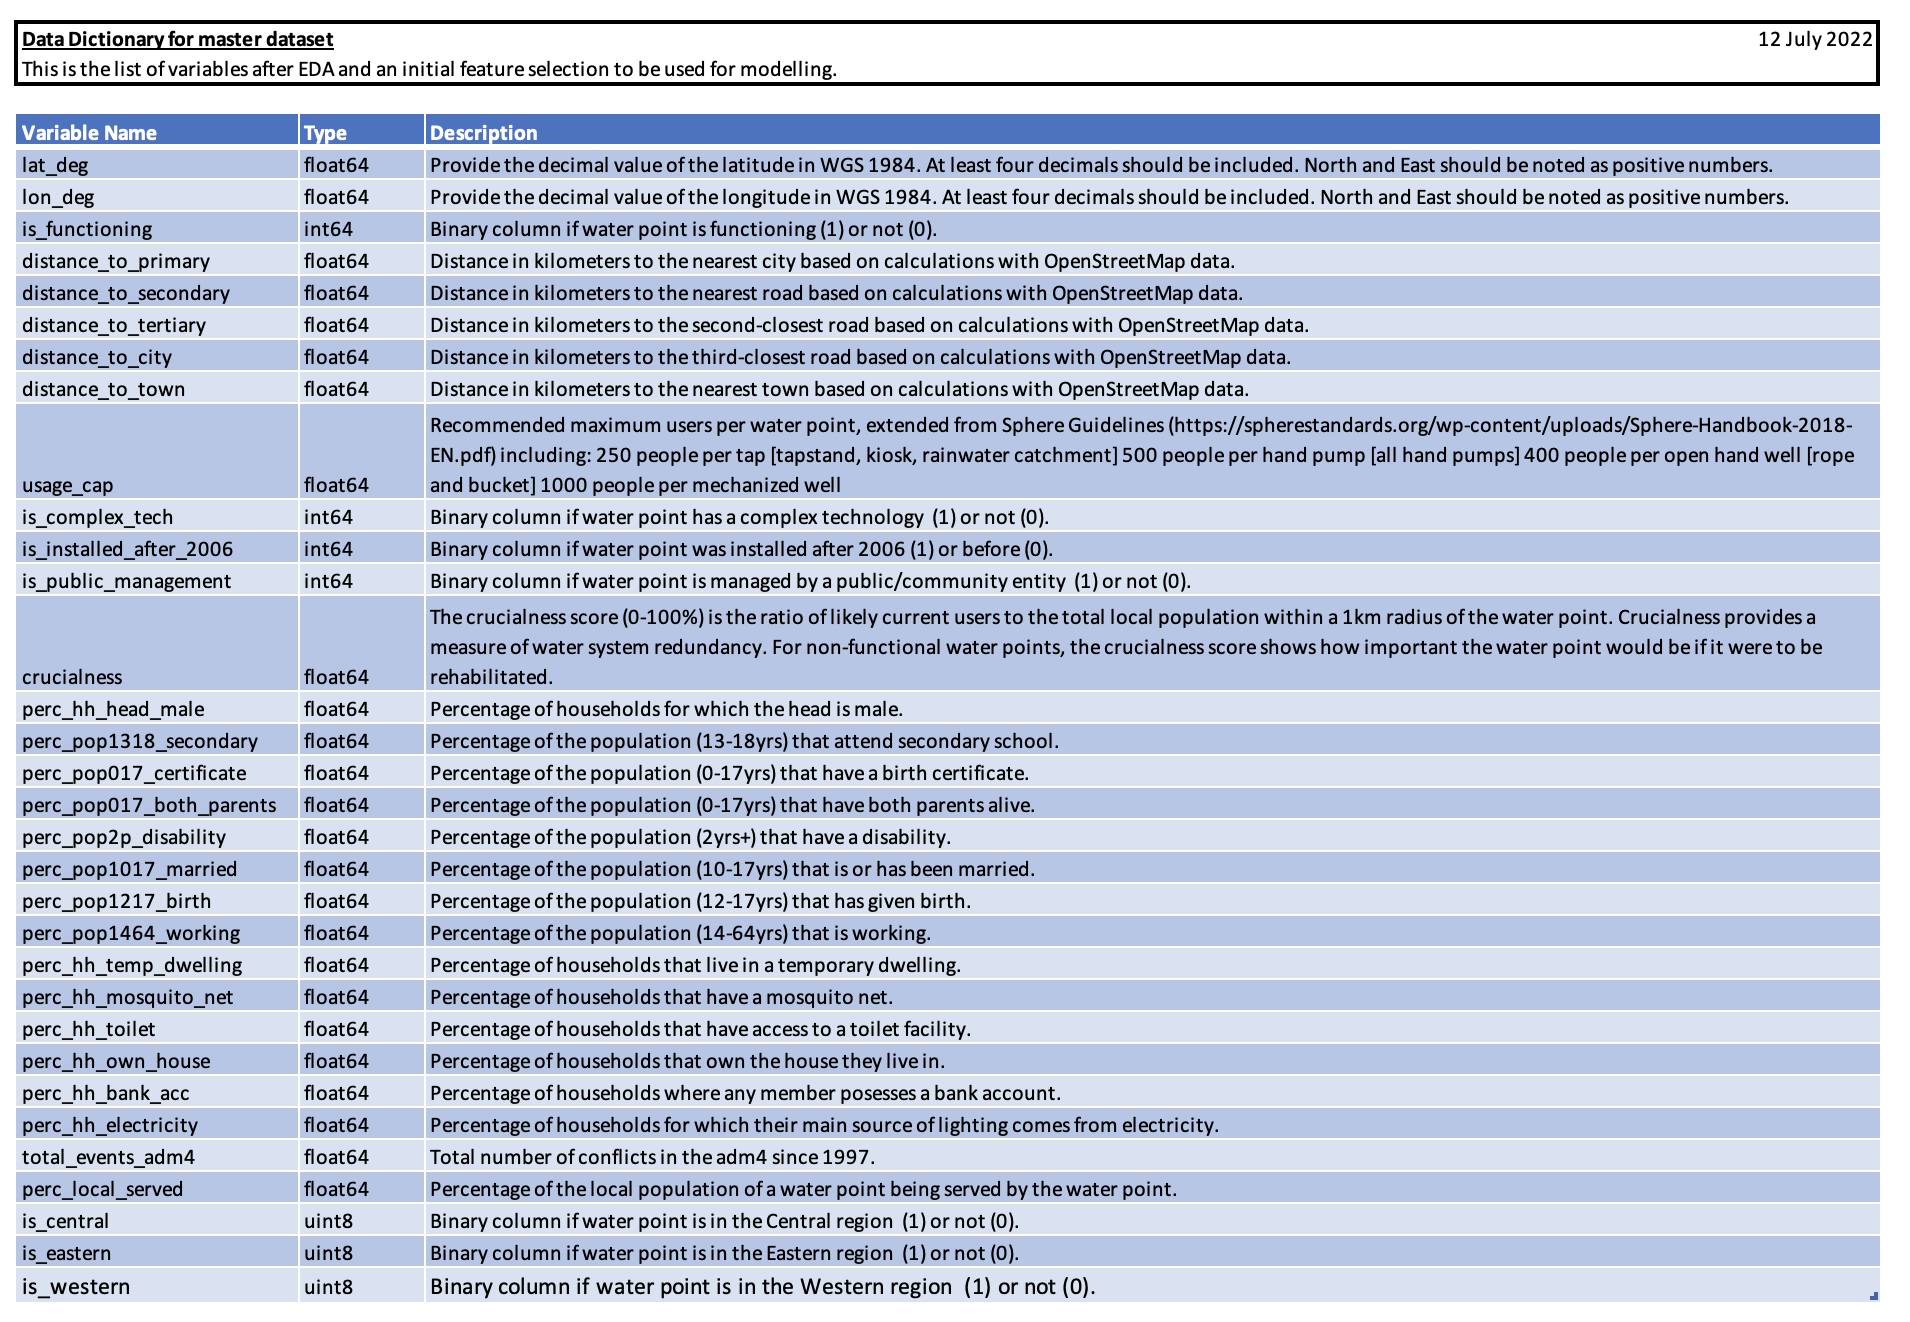

In [3]:
#data dictionary
Image(dictionary_filepath+"5-Modelling-Data-Dictionary.png")

In [4]:
# assigning X (independent) and y (dependent) variables
X =modelling_df.loc[:, modelling_df.columns != 'is_functioning']
y = modelling_df['is_functioning']

#check
print(X.shape)
print(y.shape)

(107184, 31)
(107184,)


Our independent variable (X) should have the same number of rows (107,184) than our dependent variable (y). y should only have one column as it is the outcome variable.

In [5]:
#split train test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_seed)

In [6]:
# #resampling dataset
sm = SMOTE(random_state=rand_seed)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#compre resampled dataset
print(f"Test set has {round(y_test.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_test.value_counts(normalize=True)[1]*100,1)}% functioning")
print(f"Original train set has {round(y_train.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_train.value_counts(normalize=True)[1]*100,1)}% functioning")
print(f"Resampled train set has {round(y_train_res.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_train_res.value_counts(normalize=True)[1]*100,1)}% functioning")

Test set has 19.7% non-functioning water points and 80.3% functioning
Original train set has 19.5% non-functioning water points and 80.5% functioning
Resampled train set has 50.0% non-functioning water points and 50.0% functioning


We over-sample the minority class, non-functioning water points, to get an equal distribution of our outcome variable. Note this should be done on the train set and not the test set as we should not tinker with the latter.

Note that we do not scale our data because AdaBoost is essentially and ensemble of decision trees: decision rules are made in isolation and do not compare different features when making a decision. It is not a distance-based model and thus does not need scaled data.

# Running baseline model

In [7]:
#time process
start=time.time()

#instantiate and fit
AB_base = AdaBoostClassifier(n_estimators=100, random_state=rand_seed).fit(X_train_res, y_train_res)

end=time.time()

time_fit_base=end-start

print(f"Time to fit the model on the training set is {round(time_fit_base,3)} seconds")

Time to fit the model on the training set is 32.212 seconds


The AdaBoost classifier is much quicker than our previous models (decision tree, random forest).

ROC AUC: 0.7774688074133068
PR AUC: 0.784960413878645
              precision    recall  f1-score   support

           0       0.69      0.75      0.72     68984
           1       0.72      0.66      0.69     68984

    accuracy                           0.70    137968
   macro avg       0.71      0.70      0.70    137968
weighted avg       0.71      0.70      0.70    137968



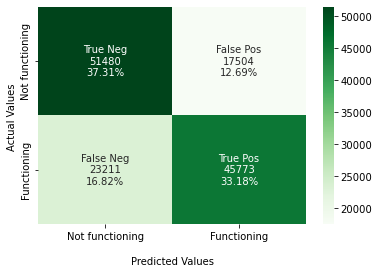

In [8]:
# get classification report for train 
fpr_train_base, tpr_train_base, roc_auc_train_base, precision_train_base_plot, recall_train_base_plot, pr_auc_train_base, time_predict_train_base = print_report(AB_base, X_train_res, y_train_res)

#storing accuracy scores
accuracy_train_base, precision_train_base, recall_train_base, f1_train_base = get_scores(AB_base, X_train_res, y_train_res)


Our training set has an accuracy score of 70%, this is very low for a training set and does not bode well for the test set scores. The model has an especially low precision score for its non-functioning labels. It labelled a lot of functioning points as non-functioning.

ROC AUC: 0.7087672475822341
PR AUC: 0.9061790563962455
              precision    recall  f1-score   support

           0       0.32      0.64      0.42      4221
           1       0.88      0.66      0.76     17216

    accuracy                           0.66     21437
   macro avg       0.60      0.65      0.59     21437
weighted avg       0.77      0.66      0.69     21437



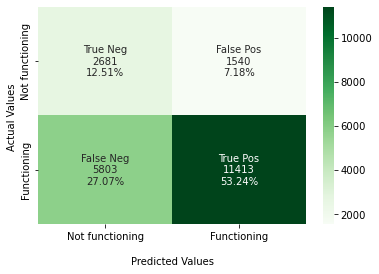

Time to predict the outcome variable for the test set is 0.326 seconds


In [9]:
# get classification report and confusion matrix for test
fpr_test_base, tpr_test_base, roc_auc_test_base, precision_test_base_plot, recall_test_base_plot, pr_auc_test_base, time_predict_test_base = print_report(AB_base, X_test, y_test)

print(f"Time to predict the outcome variable for the test set is {round(time_predict_test_base,3)} seconds")

#storing accuracy scores
accuracy_test_base, precision_test_base, recall_test_base, f1_test_base = get_scores(AB_base, X_test, y_test)

Our test set also has a low accuracy score of 66%. Similarly to the training set, its precision score for non-functioning points is incredibly low (only a third of points labelled as non-functioning actually were truly non-functioning). However, the points labelled as functioning are right 87% of the time.

# Narrowing down parameters

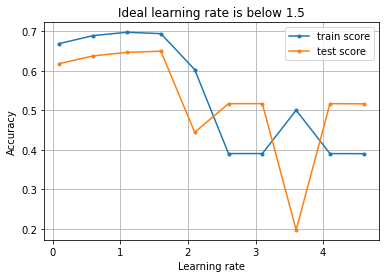

In [12]:
# look at the accuracy of the test score depending on the min sample leaf

# set range of sample leaf
learning_rate_range = np.arange(0.1, 5, 0.5)

#empty dataframe to store accuracy scores
accuracy_scores = pd.DataFrame()

for lr in learning_rate_range:

    #instantiate and fit
    AB = AdaBoostClassifier(learning_rate=lr, random_state=rand_seed).fit(
        X_train_res, y_train_res)

    # store accuracy scores
    train_score = AB.score(X_train_res, y_train_res)
    test_score = AB.score(X_test, y_test)

    # append to list
    accuracy_scores = accuracy_scores.append(
        {'Learning rate': lr, 'Train_score': train_score, 'Test_score': test_score}, ignore_index=True)

# visualise relationship between min sample leaf and accuracy
plt.figure()

plt.plot(accuracy_scores['Learning rate'],
         accuracy_scores['Train_score'], label='train score', marker='.')
plt.plot(accuracy_scores['Learning rate'],
         accuracy_scores['Test_score'], label='test score', marker='.')

plt.xlabel('Learning rate')
plt.ylabel("Accuracy")

plt.title("Ideal learning rate is less than 1.5")
plt.legend(loc='best')
plt.grid()

plt.show()

The learning rate tells the model how quickly it sould adapt to its errors. If the learning rate is high, it will make larger jumps after making an error.

We see that a learning rate of more than 1.5 becomes counterproductive as the accuracy scores fall. This is because if the learning rate is too high, usually lead to overfitting the training set.

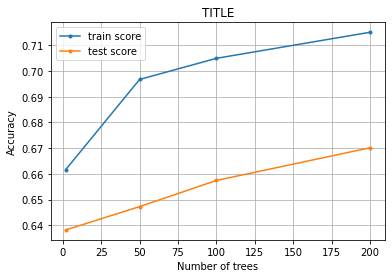

In [13]:
# look at the accuracy of the test score depending on the number of trees

# set range of depth max
n_estimators_range = [2, 50, 100, 200]

#empty dataframe to store results
accuracy_scores = pd.DataFrame()

#for gini
for n_est in n_estimators_range:

    #instantiate and fit
    AB = AdaBoostClassifier(n_estimators=n_est, random_state=rand_seed).fit(
        X_train_res, y_train_res)

    # store accuracy scores
    train_score = AB.score(X_train_res, y_train_res)
    test_score = AB.score(X_test, y_test)

    # append to list
    accuracy_scores = accuracy_scores.append(
        {'Number trees': n_est, 'Train_score': train_score, 'Test_score': test_score}, ignore_index=True)

# visualise relationship between number of trees and accuracy scores
plt.figure()

plt.plot(accuracy_scores['Number trees'],
         accuracy_scores['Train_score'], label='train score', marker='.')
plt.plot(accuracy_scores['Number trees'],
         accuracy_scores['Test_score'], label='test score', marker='.')

plt.xlabel('Number of trees')
plt.ylabel("Accuracy")

plt.title("Higher number of trees improves accuracy but risks overfitting")
plt.legend(loc='best')
plt.grid()

plt.show()

AdaBoost is an ensemble of decision trees. After calculating each tree, adaboost tweaks its loss function to try to correct for the mistakes (misclassifications) its made in the previous tree. The idea is that the more trees you have the more precise the model will become as it will find a way to classify correctly as many points as possible. We clearly see, here, that the more trees the model has, the more accurate. However, we should consider that this is computationally very expensive. This is especially expensive if we run grid searches or train on large amounts of data. In adittion, the more trees we have, the larger the chance is that we are overfitting our training set. As a result, we choose to stick to the default number of trees (50) as it has acceptable accuracy scores and will enable us to optimise other hyperparameters more quickly.

# Finding optimal hyperparameters

We run a randomised cross validation through a pipeline to find the optimal hyperparameters. We choose a randomised as opposed to a grid search because adaboost models are very expensive. For the same reasons mentioned above, we stick to the default number of trees, 50.

In [10]:
#setting hyparameter loop
learning_rate_range = np.arange(0.1, 1.5, 0.1)

# setting up which models/scalers we want to grid search
estimator = [('reduce_dim', PCA()), ('AB', AdaBoostClassifier(n_estimators=100, random_state=rand_seed))]

# defining distribution of parameters we want to compare
param_distrib = [{'AB__learning_rate': learning_rate_range,
'reduce_dim__n_components': np.arange(0.5, 0.9, 0.1)},

{'AB__learning_rate': learning_rate_range,
'reduce_dim__n_components': [None]}]

# run cross validation
pipeline_cross_val_random(estimator, param_distrib, X_train_res, y_train_res, X_test, y_test)

The model with the best CV score has the following parameters: {'reduce_dim__n_components': None, 'AB__learning_rate': 1.1}.
The best model has an accuracy score of 0.6783598451275832 on the test set


The best model has a learning rate of 1.1, note that the default learning rate is 1 in our baseline model. Let's see how that improves our accuracy.

Note how the time it took to run a randomised cross validation was extremely high, even when setting the number of trees to 50.

# Running optimised model

In [11]:
#time process
start=time.time()

#instantiate and fit
AB_opt = AdaBoostClassifier(learning_rate=1.1, random_state=rand_seed).fit(X_train_res, y_train_res)

end=time.time()

time_fit_opt=end-start

print(f"Time to fit the model on the training set is {round(time_fit_opt, 3)} seconds")

Time to fit the model on the training set is 15.299 seconds


The time to fit the model is similar to the baseline model. The only thing we really changed here is to increase the learning rate from 1 to 1.3.

ROC AUC: 0.7650327333389693
PR AUC: 0.7714155442434323
              precision    recall  f1-score   support

           0       0.68      0.74      0.71     68984
           1       0.72      0.65      0.68     68984

    accuracy                           0.70    137968
   macro avg       0.70      0.70      0.70    137968
weighted avg       0.70      0.70      0.70    137968



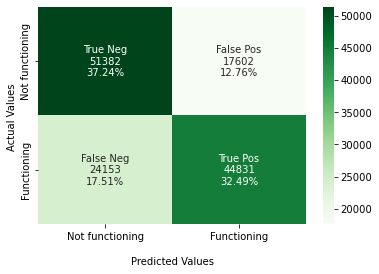

In [12]:
# get classification report for train
fpr_train_opt, tpr_train_opt, roc_auc_train_opt, precision_train_opt_plot, recall_train_opt_plot, pr_auc_train_opt, time_predict_train_opt = print_report(AB_opt, X_train_res, y_train_res)

#storing accuracy scores
accuracy_train_opt, precision_train_opt, recall_train_opt, f1_train_opt = get_scores(AB_opt, X_train_res, y_train_res)

The baseline and optimised model on our training set are near identical. It seems that the increased learning rate did not have a large effect on our accuracy metrics.

ROC AUC: 0.6966180820869101
PR AUC: 0.9014353303111194
              precision    recall  f1-score   support

           0       0.31      0.63      0.41      4221
           1       0.88      0.65      0.75     17216

    accuracy                           0.65     21437
   macro avg       0.59      0.64      0.58     21437
weighted avg       0.77      0.65      0.68     21437



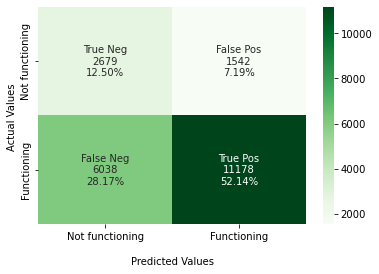

Time to predict the outcome variable for the test set is 0.152 seconds


In [13]:
# get classification report for test
fpr_test_opt, tpr_test_opt, roc_auc_test_opt, precision_test_opt_plot, recall_test_opt_plot, pr_auc_test_opt, time_predict_test_opt = print_report(AB_opt, X_test, y_test)

print(f"Time to predict the outcome variable for the test set is {round(time_predict_test_opt,3)} seconds")

#storing accuracy scores
accuracy_test_opt, precision_test_opt, recall_test_opt, f1_test_opt = get_scores(AB_opt, X_test, y_test)

Similarly to the training set, the baseline has a very slight edge in that it has a higher recall score for non-functioning water points. This means that it is identifying a larger number of non-functioning water points, which is preferable. The time it took the predict the outcome variable and all other accuracy scores on the test are nearly the same in the baseline and optimised model. 

# Comparing results

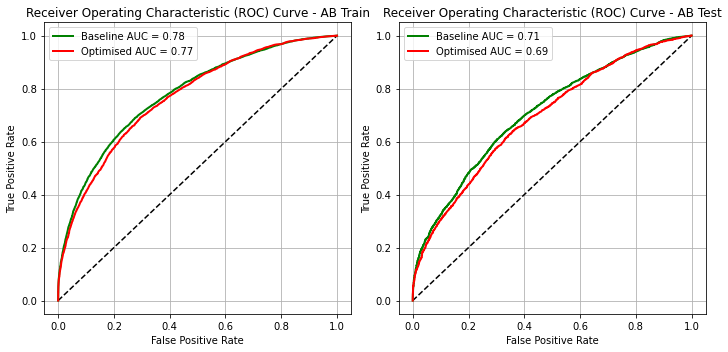

In [19]:
#visualising roc curve
plot_curve_roc('AB', fpr_train_base, tpr_train_base, roc_auc_train_base, fpr_train_opt, tpr_train_opt, roc_auc_train_opt, fpr_test_base,
 tpr_test_base, roc_auc_test_base,  fpr_test_opt, tpr_test_opt, roc_auc_test_opt)


The optimised and baseline model have near identical AUCs. We go with the baseline model with a learning rate of 1 as it performs very slightly better on its recall score for non-functioning water points.

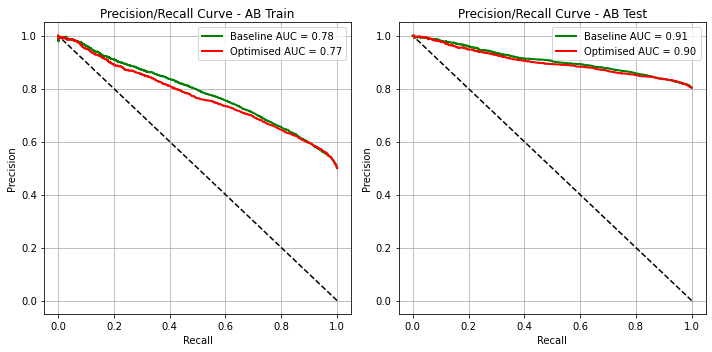

In [20]:
#visualising precision/recall curve
plot_curve_prec_recall('AB', recall_train_base_plot, precision_train_base_plot, pr_auc_train_base, recall_train_opt_plot, precision_train_opt_plot, pr_auc_train_opt,
 recall_test_base_plot, precision_test_base_plot,  pr_auc_test_base, recall_test_opt_plot, precision_test_opt_plot, pr_auc_test_opt)


# Visualising feature importance

In [28]:
#visualising coefficient importance
coeff_bar_chart(AB_base.feature_importances_, X.columns, t=False)

,feature,coefficient
11,crucialness,0.09
26,total_events_adm4,0.08
1,lon_deg,0.07
24,perc_hh_bank_acc,0.05
17,perc_pop1017_married,0.05


For the first time, the number of conflicts/violent events becomes an important feature in a model. Maybe the fact that this is a boosting model enables it to find more hidden links with water point functionality. This is definitely something we should explore next with a more powerful boosting method, XGBoost. We see that most demographic variables are not given any importance in the model. It is mostly water point features such as usage capacity, crucialness and public management.

In [ ]:
#hypotheses table
Image(dictionary_filepath+"6-Hypotheses.png")

# Exporting

In [32]:
#export model results-this is very large and cannot be pushed to our git repo
joblib.dump(AB_base, model_filepath+'adaboost_model.sav')

['/Users/thomasadler/Desktop/futuristic-platipus/models/adaboost_model.sav']

In [33]:
#export best model in dataframe
d = {'Model':['AdaBoost'], 'Parameters':['Learning rate=1, Number of trees=50'], 'Accuracy Train': [accuracy_train_base],\
    'Precision Train': [precision_train_base], 'Recall Train': [recall_train_base], 'F1 Train': [f1_train_base], 'FPR Train Plot': [fpr_train_base],\
        'TPR Train Plot':[tpr_train_base], 'ROC AUC Train':[roc_auc_train_base], 'Precision Train Plot': [precision_train_base_plot],\
            'Recall Train Plot':[recall_train_base_plot], 'PR AUC Train':[pr_auc_train_base], 'Accuracy Test': accuracy_test_base,\
                'Precision Test': [precision_test_base], 'Recall Test': [recall_test_base], 'F1 Test': [f1_test_base], 'FPR Test Plot': [fpr_test_base],\
                    'TPR Test Plot':[tpr_test_base], 'ROC AUC Test':[roc_auc_test_base], 'Precision Test Plot': [precision_test_base_plot],\
                        'Recall Test Plot':[recall_test_base_plot], 'PR AUC Test':[pr_auc_test_base], 'Time Fit': time_fit_base, 'Time Predict': time_predict_test_base, "Recall Negative Test": 0.64}

#to dataframe
best_model_result_df=pd.DataFrame(data=d)

#check
best_model_result_df

,Model,Parameters,Accuracy Train,Precision Train,Recall Train,F1 Train,FPR Train Plot,TPR Train Plot,ROC AUC Train,Precision Train Plot,...,Recall Test,F1 Test,FPR Test Plot,TPR Test Plot,ROC AUC Test,Precision Test Plot,Recall Test Plot,PR AUC Test,Time Fit,Time Predict
0,AdaBoost,"Learning rate=1, Number of trees=50",0.704895,0.706307,0.704895,0.70439,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.4496115041168967e-05, 0.00010147280528...",0.777469,"[0.5000181208005045, 0.5000144967454806, 0.500...",...,0.657461,0.690728,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.808550185873606e-05, 0.000522769516728...",0.708767,"[0.8031349132300802, 0.8031731217918805, 0.803...","[1.0, 0.9997676579925651, 0.9997095724907064, ...",0.906179,54.600921,0.75764


In [34]:
#export new dataset
best_model_result_df.to_csv(model_filepath + 'adaboost_model.csv')